# Improve Customer Experience by Minimizing Complaints Filed

# Introduction
98% of complaints sent to companies get timely responses <br>
Complaints give insights into problems people are experiencing in the marketplace in order to help regulate consumer financial products and services under existing federal consumer financial laws <br>
Every week, Consumer Financial Protection Bureau (CFPB) gets sent over 10,000 complaints about financial products and services to companies for response

# Dataset

18 variables, 2.56M observations from 2011-2022 <br>
Selecting the past 3 years from 2019 to 2022 for analysis <br>
Dataset obtained from CFPB website <br>
Find features correlated to complaints to decrease future complaints filed <br>

# Research Questions
1. Gain insights of complaints filed over the past 3 years through exploratory data analysis
2. Improve customer experience by reducing the number of complaints being filed on CFPB
3. Select most significant factors related to complaints to minimize complaints

# Data Preprocessing and Preparation

In [172]:
from datacleaner import autoclean
import pandas as pd
import os
import numpy as np
import seaborn as sns
from cleantext import clean
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import chi2
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from xgboost import plot_importance

%matplotlib inline

In [173]:
df = pd.read_csv("complaints.csv",sep=',',low_memory=False)
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2017-05-03,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute about a purchase on your statement,NaN,NaN,JPMORGAN CHASE & CO.,MI,48038,NaN,NaN,Referral,2017-07-31,Closed with explanation,Yes,NaN,2547805
1,2019-05-03,Student loan,Private student loan,Struggling to repay your loan,Can't get other flexible options for repaying your loan,NaN,NaN,Ameritech Financial,FL,33023,NaN,Consent not provided,Web,2019-05-15,Untimely response,No,NaN,3231257
2,2017-07-30,"Money transfer, virtual currency, or money service",International money transfer,Fraud or scam,NaN,PayPal Resolution Center ignored their own policies in the determination of a dispute or complai...,NaN,Alliance Data Card Services,FL,34668,NaN,Consent provided,Web,2017-08-03,Closed with explanation,Yes,NaN,2589241
3,2022-01-26,Mortgage,Reverse mortgage,Trouble during payment process,NaN,I am the personal representative of my sister 's estate. When preparing to sell her home I disco...,NaN,Ocwen Financial Corporation,AZ,85120,Older American,Consent provided,Web,2022-01-26,Closed with explanation,Yes,NaN,5149935
4,2017-07-31,Checking or savings account,Checking account,Problem with a lender or other company charging your account,Transaction was not authorized,"Hello, three months ago I was in the process of obtaining a mortgage and signed up with Experian...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,Experian Information Solutions Inc.,OH,45040,NaN,Consent provided,Web,2017-07-31,Closed with monetary relief,Yes,NaN,2590054


In [174]:
#Generate descriptive stats for count, number of unique, etc.
df.describe(include='all').head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
count,2569479,2569479,2334316,2569479,1915979,900077,1064827,2569479,2530225,2529982,304034,1811601,2569479,2569479,2569476,2569479,768458,2.569479e+06
unique,3773,18,76,165,221,801671,11,6330,63,33838,3,4,7,3722,8,2,2,NaN
top,2017-09-08,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,There are many mistakes appear in my report without my understanding.,Company has responded to the consumer and the CFPB and chooses not to provide a public response,"EQUIFAX, INC.",CA,30349,Servicemember,Consent provided,Web,2017-09-08,Closed with explanation,Yes,No,NaN
freq,3553,1026282,1013653,616269,393104,1035,870413,407655,325508,3815,163183,900483,2102314,3387,2084478,2523185,620080,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.053386e+06


In [175]:
#renamed column names that contain "-", "?" ," " with underscores
df.rename(columns={'Date received':'Date_received','Sub-product':'Sub_product','Sub-issue':'Sub_issue',
                  'Consumer complaint narrative':'Consumer_complaint_narrative',
                   'Company public response':'Company_public_response','ZIP code':'Zip_code',
                  'Consumer consent provided?':'Consumer_consent_provided','Submitted via':'Submitted_via',
                  'Date sent to company':'Date_sent_to_company',
                   'Company response to consumer':'Company_response_to_consumer',
                   'Timely response?':'Timely_response','Consumer disputed?':'Consumer_disputed',
                  'Complaint ID':'Complaint_ID'},inplace=True)
df.head()

,Date_received,Product,Sub_product,Issue,Sub_issue,Consumer_complaint_narrative,Company_public_response,Company,State,Zip_code,Tags,Consumer_consent_provided,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Timely_response,Consumer_disputed,Complaint_ID
0,2017-05-03,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute about a purchase on your statement,NaN,NaN,JPMORGAN CHASE & CO.,MI,48038,NaN,NaN,Referral,2017-07-31,Closed with explanation,Yes,NaN,2547805
1,2019-05-03,Student loan,Private student loan,Struggling to repay your loan,Can't get other flexible options for repaying your loan,NaN,NaN,Ameritech Financial,FL,33023,NaN,Consent not provided,Web,2019-05-15,Untimely response,No,NaN,3231257
2,2017-07-30,"Money transfer, virtual currency, or money service",International money transfer,Fraud or scam,NaN,PayPal Resolution Center ignored their own policies in the determination of a dispute or complai...,NaN,Alliance Data Card Services,FL,34668,NaN,Consent provided,Web,2017-08-03,Closed with explanation,Yes,NaN,2589241
3,2022-01-26,Mortgage,Reverse mortgage,Trouble during payment process,NaN,I am the personal representative of my sister 's estate. When preparing to sell her home I disco...,NaN,Ocwen Financial Corporation,AZ,85120,Older American,Consent provided,Web,2022-01-26,Closed with explanation,Yes,NaN,5149935
4,2017-07-31,Checking or savings account,Checking account,Problem with a lender or other company charging your account,Transaction was not authorized,"Hello, three months ago I was in the process of obtaining a mortgage and signed up with Experian...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,Experian Information Solutions Inc.,OH,45040,NaN,Consent provided,Web,2017-07-31,Closed with monetary relief,Yes,NaN,2590054


In [176]:
df['Date_received'] = pd.to_datetime(df['Date_received'])
df['year_received'], df['month_received'] = df['Date_received'].dt.year, df['Date_received'].dt.month
df.head()

,Date_received,Product,Sub_product,Issue,Sub_issue,Consumer_complaint_narrative,Company_public_response,Company,State,Zip_code,Tags,Consumer_consent_provided,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Timely_response,Consumer_disputed,Complaint_ID,year_received,month_received
0,2017-05-03,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute about a purchase on your statement,NaN,NaN,JPMORGAN CHASE & CO.,MI,48038,NaN,NaN,Referral,2017-07-31,Closed with explanation,Yes,NaN,2547805,2017,5
1,2019-05-03,Student loan,Private student loan,Struggling to repay your loan,Can't get other flexible options for repaying your loan,NaN,NaN,Ameritech Financial,FL,33023,NaN,Consent not provided,Web,2019-05-15,Untimely response,No,NaN,3231257,2019,5
2,2017-07-30,"Money transfer, virtual currency, or money service",International money transfer,Fraud or scam,NaN,PayPal Resolution Center ignored their own policies in the determination of a dispute or complai...,NaN,Alliance Data Card Services,FL,34668,NaN,Consent provided,Web,2017-08-03,Closed with explanation,Yes,NaN,2589241,2017,7
3,2022-01-26,Mortgage,Reverse mortgage,Trouble during payment process,NaN,I am the personal representative of my sister 's estate. When preparing to sell her home I disco...,NaN,Ocwen Financial Corporation,AZ,85120,Older American,Consent provided,Web,2022-01-26,Closed with explanation,Yes,NaN,5149935,2022,1
4,2017-07-31,Checking or savings account,Checking account,Problem with a lender or other company charging your account,Transaction was not authorized,"Hello, three months ago I was in the process of obtaining a mortgage and signed up with Experian...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,Experian Information Solutions Inc.,OH,45040,NaN,Consent provided,Web,2017-07-31,Closed with monetary relief,Yes,NaN,2590054,2017,7


In [177]:
#Show the earliest and latest dates to select the most recent 3 years
print(df['Date_received'].min(),df['Date_received'].max())

2011-12-01 00:00:00 2022-03-31 00:00:00


In [178]:
#select past 3 years
df1 = df[(df['Date_received'] > '2019-03-31') & (df['Date_sent_to_company'] > '2019-03-31') &
         (df['Date_sent_to_company'] <= '2022-03-31') & (df['Date_received'] <= '2022-03-31') ]
df1.head()

,Date_received,Product,Sub_product,Issue,Sub_issue,Consumer_complaint_narrative,Company_public_response,Company,State,Zip_code,Tags,Consumer_consent_provided,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Timely_response,Consumer_disputed,Complaint_ID,year_received,month_received
1,2019-05-03,Student loan,Private student loan,Struggling to repay your loan,Can't get other flexible options for repaying your loan,NaN,NaN,Ameritech Financial,FL,33023,NaN,Consent not provided,Web,2019-05-15,Untimely response,No,NaN,3231257,2019,5
3,2022-01-26,Mortgage,Reverse mortgage,Trouble during payment process,NaN,I am the personal representative of my sister 's estate. When preparing to sell her home I disco...,NaN,Ocwen Financial Corporation,AZ,85120,Older American,Consent provided,Web,2022-01-26,Closed with explanation,Yes,NaN,5149935,2022,1
7,2019-05-02,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the CFPB and chooses not to provide a public response,Experian Information Solutions Inc.,FL,33313,NaN,Other,Web,2019-05-02,Closed with explanation,Yes,NaN,3229956,2019,5
8,2019-05-22,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,NaN,Company has responded to the consumer and the CFPB and chooses not to provide a public response,Specialized Loan Servicing Holdings LLC,IN,46060,NaN,Consent not provided,Web,2019-05-22,Closed with explanation,Yes,NaN,3251012,2019,5
9,2022-03-20,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,MD,21133,NaN,NaN,Web,2022-03-20,In progress,Yes,NaN,5344096,2022,3


In [179]:
#Drop rows where complaint is null
df2 = df1[pd.notnull(df1['Consumer_complaint_narrative'])]
df2.head()

,Date_received,Product,Sub_product,Issue,Sub_issue,Consumer_complaint_narrative,Company_public_response,Company,State,Zip_code,Tags,Consumer_consent_provided,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Timely_response,Consumer_disputed,Complaint_ID,year_received,month_received
3,2022-01-26,Mortgage,Reverse mortgage,Trouble during payment process,NaN,I am the personal representative of my sister 's estate. When preparing to sell her home I disco...,NaN,Ocwen Financial Corporation,AZ,85120,Older American,Consent provided,Web,2022-01-26,Closed with explanation,Yes,NaN,5149935,2022,1
39,2022-03-03,Debt collection,Other debt,False statements or representation,Attempted to collect wrong amount,I financed some expensive dental procedures through XXXX XXXX. The contract I signed had no late...,Company believes it acted appropriately as authorized by contract or law,"Herbert P. Sears Co., Inc.",AZ,85007,NaN,Consent provided,Web,2022-03-03,Closed with explanation,Yes,NaN,5279657,2022,3
41,2019-11-22,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Personal information incorrect,Today XX/XX/XXXX went online to dispute the incorrect personal information and it says This requ...,Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",FL,33025,NaN,Consent provided,Web,2019-11-22,Closed with explanation,Yes,NaN,3446975,2019,11
73,2020-03-10,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Account status incorrect,I have been trying to dispute this inaccurate late payment with comenity bank for months they ar...,NaN,Alliance Data Card Services,OH,45240,NaN,Consent provided,Web,2020-03-10,Closed with explanation,Yes,NaN,3561246,2020,3
105,2020-04-08,Credit card or prepaid card,Store credit card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute about a purchase on your statement,"I ordered some clothing online, two purchases in the amounts of {$140.00} & {$81.00} The merchan...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"CITIBANK, N.A.",FL,34287,Older American,Consent provided,Web,2020-04-08,Closed with explanation,Yes,NaN,3597341,2020,4


In [180]:
#Count number of values per column: 500K
df2.count()

Date_received                   505372
Product                         505372
Sub_product                     505372
Issue                           505372
Sub_issue                       442246
Consumer_complaint_narrative    505372
Company_public_response         248673
Company                         505372
State                           502728
Zip_code                        502584
Tags                             71713
Consumer_consent_provided       505372
Submitted_via                   505372
Date_sent_to_company            505372
Company_response_to_consumer    505372
Timely_response                 505372
Consumer_disputed                    0
Complaint_ID                    505372
year_received                   505372
month_received                  505372
dtype: int64

In [181]:
#check data types for each column
df2.dtypes

Date_received                   datetime64[ns]
Product                                 object
Sub_product                             object
Issue                                   object
Sub_issue                               object
Consumer_complaint_narrative            object
Company_public_response                 object
Company                                 object
State                                   object
Zip_code                                object
Tags                                    object
Consumer_consent_provided               object
Submitted_via                           object
Date_sent_to_company                    object
Company_response_to_consumer            object
Timely_response                         object
Consumer_disputed                       object
Complaint_ID                             int64
year_received                            int64
month_received                           int64
dtype: object

In [182]:
#check number of missing values per column
df2.isna().sum()

Date_received                        0
Product                              0
Sub_product                          0
Issue                                0
Sub_issue                        63126
Consumer_complaint_narrative         0
Company_public_response         256699
Company                              0
State                             2644
Zip_code                          2788
Tags                            433659
Consumer_consent_provided            0
Submitted_via                        0
Date_sent_to_company                 0
Company_response_to_consumer         0
Timely_response                      0
Consumer_disputed               505372
Complaint_ID                         0
year_received                        0
month_received                       0
dtype: int64

In [183]:
#consumer disputed & tags 100% and 86% all null -> drop these columns
df3=df2.drop(columns=['Consumer_disputed','Tags'])
df3.head()

,Date_received,Product,Sub_product,Issue,Sub_issue,Consumer_complaint_narrative,Company_public_response,Company,State,Zip_code,Consumer_consent_provided,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Timely_response,Complaint_ID,year_received,month_received
3,2022-01-26,Mortgage,Reverse mortgage,Trouble during payment process,NaN,I am the personal representative of my sister 's estate. When preparing to sell her home I disco...,NaN,Ocwen Financial Corporation,AZ,85120,Consent provided,Web,2022-01-26,Closed with explanation,Yes,5149935,2022,1
39,2022-03-03,Debt collection,Other debt,False statements or representation,Attempted to collect wrong amount,I financed some expensive dental procedures through XXXX XXXX. The contract I signed had no late...,Company believes it acted appropriately as authorized by contract or law,"Herbert P. Sears Co., Inc.",AZ,85007,Consent provided,Web,2022-03-03,Closed with explanation,Yes,5279657,2022,3
41,2019-11-22,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Personal information incorrect,Today XX/XX/XXXX went online to dispute the incorrect personal information and it says This requ...,Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",FL,33025,Consent provided,Web,2019-11-22,Closed with explanation,Yes,3446975,2019,11
73,2020-03-10,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Account status incorrect,I have been trying to dispute this inaccurate late payment with comenity bank for months they ar...,NaN,Alliance Data Card Services,OH,45240,Consent provided,Web,2020-03-10,Closed with explanation,Yes,3561246,2020,3
105,2020-04-08,Credit card or prepaid card,Store credit card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute about a purchase on your statement,"I ordered some clothing online, two purchases in the amounts of {$140.00} & {$81.00} The merchan...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"CITIBANK, N.A.",FL,34287,Consent provided,Web,2020-04-08,Closed with explanation,Yes,3597341,2020,4


In [184]:
df3.isna().sum()

Date_received                        0
Product                              0
Sub_product                          0
Issue                                0
Sub_issue                        63126
Consumer_complaint_narrative         0
Company_public_response         256699
Company                              0
State                             2644
Zip_code                          2788
Consumer_consent_provided            0
Submitted_via                        0
Date_sent_to_company                 0
Company_response_to_consumer         0
Timely_response                      0
Complaint_ID                         0
year_received                        0
month_received                       0
dtype: int64

In [185]:
# filling with most common class
from sklearn.impute import SimpleImputer

In [186]:
#Impute null values with most common from each column
df_imputed = df3.fillna(df3.mode().iloc[0])
df_imputed.head()

,Date_received,Product,Sub_product,Issue,Sub_issue,Consumer_complaint_narrative,Company_public_response,Company,State,Zip_code,Consumer_consent_provided,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Timely_response,Complaint_ID,year_received,month_received
3,2022-01-26,Mortgage,Reverse mortgage,Trouble during payment process,Information belongs to someone else,I am the personal representative of my sister 's estate. When preparing to sell her home I disco...,Company has responded to the consumer and the CFPB and chooses not to provide a public response,Ocwen Financial Corporation,AZ,85120,Consent provided,Web,2022-01-26,Closed with explanation,Yes,5149935,2022,1
39,2022-03-03,Debt collection,Other debt,False statements or representation,Attempted to collect wrong amount,I financed some expensive dental procedures through XXXX XXXX. The contract I signed had no late...,Company believes it acted appropriately as authorized by contract or law,"Herbert P. Sears Co., Inc.",AZ,85007,Consent provided,Web,2022-03-03,Closed with explanation,Yes,5279657,2022,3
41,2019-11-22,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Personal information incorrect,Today XX/XX/XXXX went online to dispute the incorrect personal information and it says This requ...,Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",FL,33025,Consent provided,Web,2019-11-22,Closed with explanation,Yes,3446975,2019,11
73,2020-03-10,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Account status incorrect,I have been trying to dispute this inaccurate late payment with comenity bank for months they ar...,Company has responded to the consumer and the CFPB and chooses not to provide a public response,Alliance Data Card Services,OH,45240,Consent provided,Web,2020-03-10,Closed with explanation,Yes,3561246,2020,3
105,2020-04-08,Credit card or prepaid card,Store credit card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute about a purchase on your statement,"I ordered some clothing online, two purchases in the amounts of {$140.00} & {$81.00} The merchan...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"CITIBANK, N.A.",FL,34287,Consent provided,Web,2020-04-08,Closed with explanation,Yes,3597341,2020,4


In [187]:
df_imputed.count()

Date_received                   505372
Product                         505372
Sub_product                     505372
Issue                           505372
Sub_issue                       505372
Consumer_complaint_narrative    505372
Company_public_response         505372
Company                         505372
State                           505372
Zip_code                        505372
Consumer_consent_provided       505372
Submitted_via                   505372
Date_sent_to_company            505372
Company_response_to_consumer    505372
Timely_response                 505372
Complaint_ID                    505372
year_received                   505372
month_received                  505372
dtype: int64

In [188]:
import pandas_datareader.data as web
import datetime as dt

# Exploratory Data Analysis

<AxesSubplot:title={'center':'Product Complaints'}, xlabel='Product', ylabel='count'>

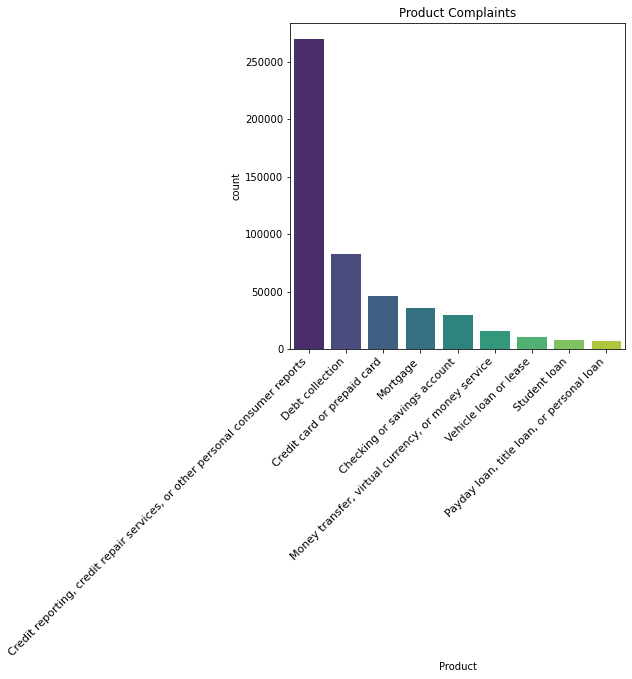

In [190]:
#most complaints came from credit reporting and debt collection
fig,ax = plt.subplots(figsize=(6,6))
plt.title('Product Complaints')
plt.xticks(rotation=45,fontsize=11,ha="right")
sns.countplot(x='Product', palette="viridis",
              data=df_imputed, order = df_imputed['Product'].value_counts().iloc[:10].index)

<AxesSubplot:title={'center':'Sub-product Complaints'}, xlabel='Sub_product', ylabel='count'>

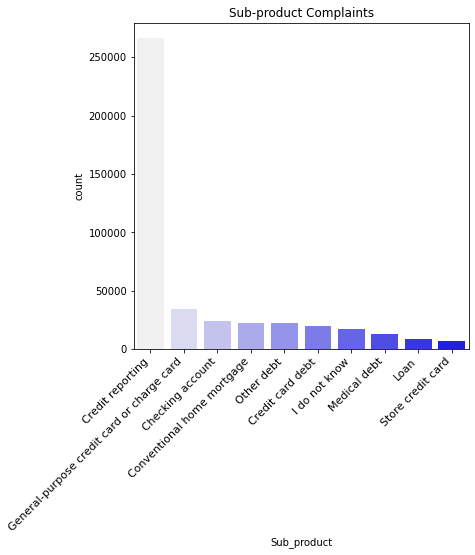

In [191]:
fig,ax = plt.subplots(figsize=(6,6))
plt.title('Sub-product Complaints')
plt.xticks(rotation=45,fontsize=11,ha="right")
sns.countplot(x='Sub_product', palette="light:blue",
              data=df_imputed,order = df_imputed['Sub_product'].value_counts().iloc[:10].index)

#Sub-products with most complaints: credit reporting is the most

<AxesSubplot:title={'center':'Company Complaints'}, xlabel='Company', ylabel='count'>

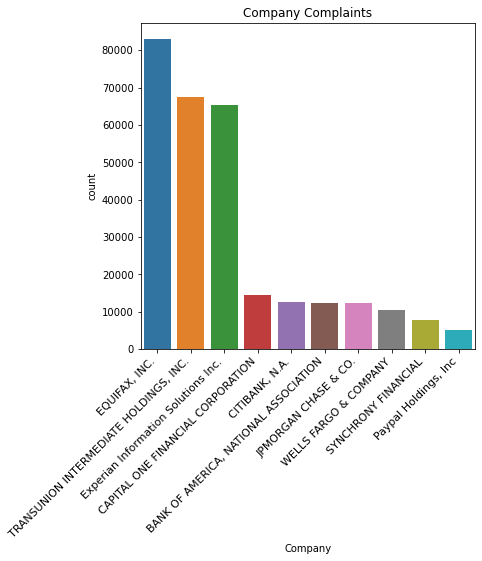

In [192]:
fig,ax = plt.subplots(figsize=(6,6))
plt.title('Company Complaints')
plt.xticks(rotation=45,fontsize=11,ha="right")
sns.countplot(x='Company', data=df_imputed, order = df_imputed['Company'].value_counts().iloc[:10].index)
#most complaints came from Equifax, Transunion Intermediate Holdings, and Experian

<AxesSubplot:title={'center':'Issue Complaints'}, xlabel='Issue', ylabel='count'>

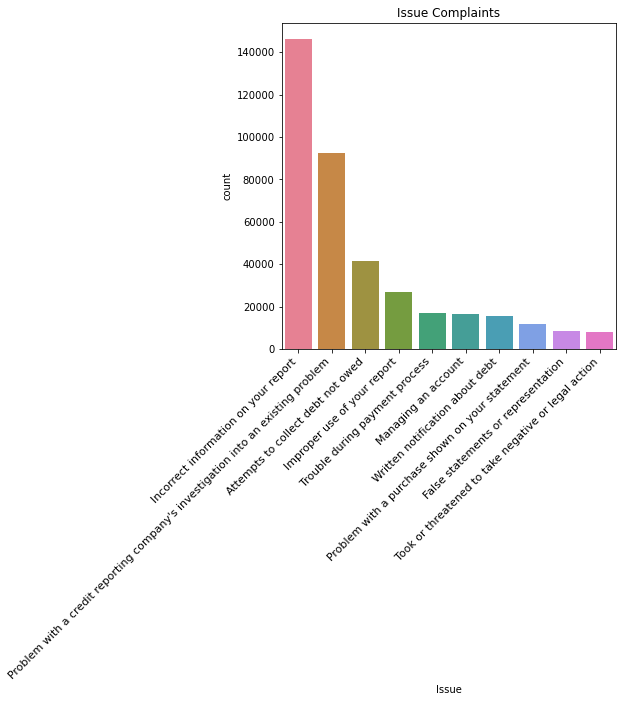

In [193]:
fig,ax = plt.subplots(figsize=(6,6))
plt.xticks(rotation=45,fontsize=11,ha="right")
plt.title('Issue Complaints')
sns.countplot(x='Issue', palette="husl",
              data=df_imputed,order = df_imputed['Issue'].value_counts().iloc[:10].index)
#Issues with most complaints: incorrect info

<AxesSubplot:title={'center':'Sub-issue Complaints'}, xlabel='Sub_issue', ylabel='count'>

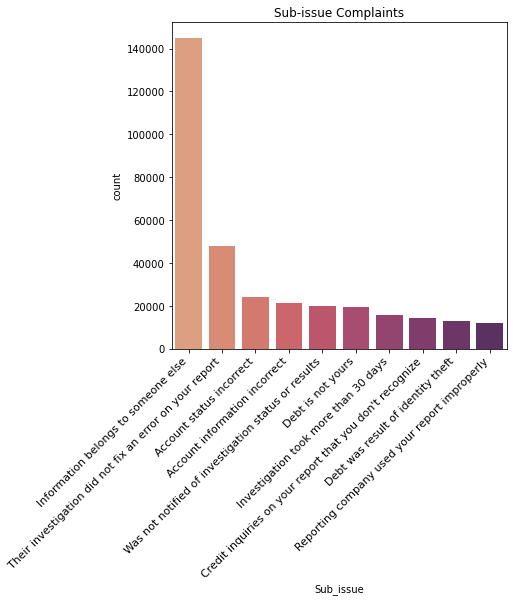

In [194]:
fig,ax = plt.subplots(figsize=(6,6))
plt.title('Sub-issue Complaints')
plt.xticks(rotation=45,fontsize=11,ha="right")
sns.countplot(x='Sub_issue',palette="flare",
              data=df_imputed,order = df_imputed['Sub_issue'].value_counts().iloc[:10].index)
#Sub-Issues with most complaints

<AxesSubplot:title={'center':'Timely Response or not'}, xlabel='Timely_response', ylabel='count'>

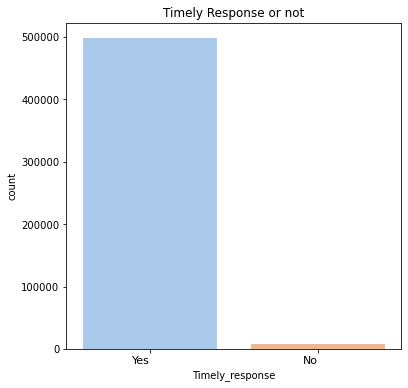

In [195]:
fig,ax = plt.subplots(figsize=(6,6))
plt.title('Timely Response or not')
plt.xticks(fontsize=11,ha="right")
sns.countplot(x='Timely_response',data=df_imputed,palette="pastel")
#most companies gave timely responses

In [196]:
#424,539 distinct complaints from consumers
len(pd.unique(df_imputed['Consumer_complaint_narrative']))

424539

In [197]:
#shows some consumer complaints
df_imputed['Consumer_complaint_narrative'].head()

3      I am the personal representative of my sister 's estate. When preparing to sell her home I disco...
39     I financed some expensive dental procedures through XXXX XXXX. The contract I signed had no late...
41     Today XX/XX/XXXX went online to dispute the incorrect personal information and it says This requ...
73     I have been trying to dispute this inaccurate late payment with comenity bank for months they ar...
105    I ordered some clothing online, two purchases in the amounts of {$140.00} & {$81.00} The merchan...
Name: Consumer_complaint_narrative, dtype: object

<AxesSubplot:title={'center':'Complaints by State'}, xlabel='State', ylabel='count'>

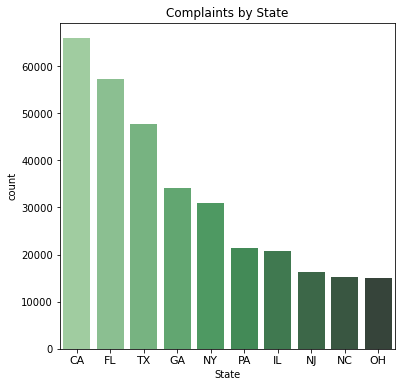

In [198]:
fig,ax = plt.subplots(figsize=(6,6))
plt.title('Complaints by State')
plt.xticks(fontsize=11)
sns.countplot(x='State', palette="Greens_d",
              data=df_imputed,order = df_imputed['State'].value_counts().iloc[:10].index)
#most complaints by states. California, Florida, and Texas have the most but they're also the largest states.

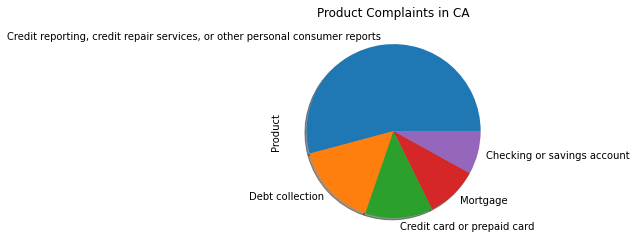

In [199]:
df_imputed[df_imputed['State'] == 'CA']['Product'].value_counts().head(5).plot.pie(explode=[0,0,0,0,0],shadow=True)
plt.title('Product Complaints in CA')
# Unsquish the pie.
plt.gca().set_aspect('equal')

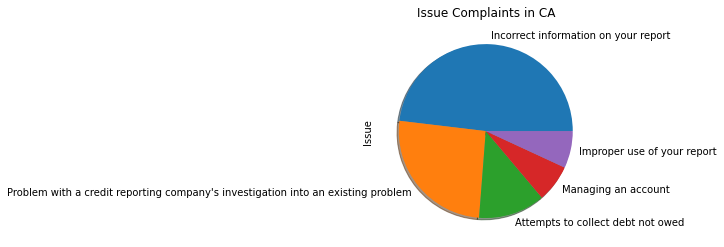

In [200]:
df_imputed[df_imputed['State'] == 'CA']['Issue'].value_counts().head(5).plot.pie(explode=[0,0,0,0,0],shadow=True)
plt.title('Issue Complaints in CA')
# Unsquish the pie.
plt.gca().set_aspect('equal')

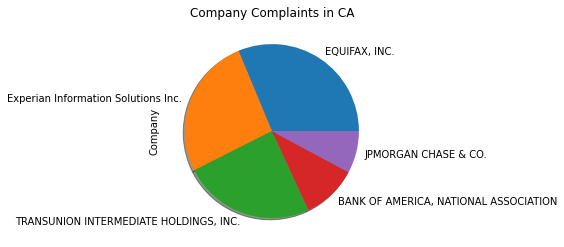

In [201]:
df_imputed[df_imputed['State'] == 'CA']['Company'].value_counts().head(5).plot.pie(explode=[0,0,0,0,0],shadow=True)
plt.title('Company Complaints in CA')
# Unsquish the pie.
plt.gca().set_aspect('equal')

[Text(0.5, 0, 'Count'), Text(0, 0.5, 'Company response')]

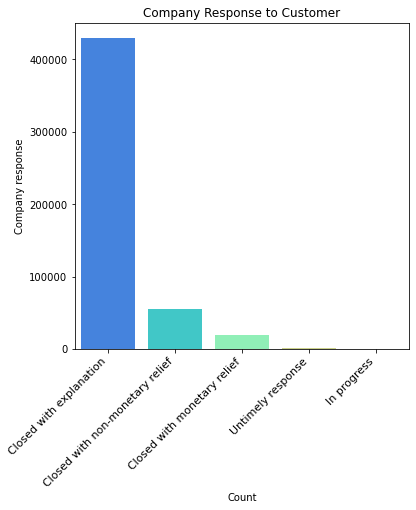

In [202]:
fig,ax = plt.subplots(figsize=(6,6))
plt.xticks(rotation=45,fontsize=11,ha="right")
plt.title('Company Response to Customer')
sns.countplot(x='Company_response_to_consumer',data=df_imputed,
              order = df_imputed['Company_response_to_consumer'].value_counts().index, 
              palette='rainbow').set(xlabel='Count', ylabel='Company response')

#Number of complaints based on company response to consumer. Most closed with explanation

In [203]:
p_product_discussions = round(df_imputed["Product"].value_counts() / len(df_imputed["Product"]) * 100,2)

print(p_product_discussions)

labels = list(p_product_discussions.index)
values = p_product_discussions.values.tolist()
colors = ['#F78181', '#F5A9BC', '#2E9AFE', '#58FA58', '#FAAC58', '#088A85', '#8A0808', '#848484', '#F781F3', '#D7DF01', '#2E2EFE']


product_pie = go.Pie(labels=labels, values=values, 
                          marker=dict(colors=colors,
                         line=dict(color='#000000', width=2)))

layout = go.Layout(title='Product Types')
fig = go.Figure(data=[product_pie], layout=layout)
iplot(fig)


Credit reporting, credit repair services, or other personal consumer reports    53.45
Debt collection                                                                 16.39
Credit card or prepaid card                                                      9.06
Mortgage                                                                         7.09
Checking or savings account                                                      5.82
Money transfer, virtual currency, or money service                               3.12
Vehicle loan or lease                                                            2.16
Student loan                                                                     1.56
Payday loan, title loan, or personal loan                                        1.36
Name: Product, dtype: float64


In [204]:

df.head()

,Date_received,Product,Sub_product,Issue,Sub_issue,Consumer_complaint_narrative,Company_public_response,Company,State,Zip_code,Tags,Consumer_consent_provided,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Timely_response,Consumer_disputed,Complaint_ID,year_received,month_received
0,2017-05-03,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute about a purchase on your statement,NaN,NaN,JPMORGAN CHASE & CO.,MI,48038,NaN,NaN,Referral,2017-07-31,Closed with explanation,Yes,NaN,2547805,2017,5
1,2019-05-03,Student loan,Private student loan,Struggling to repay your loan,Can't get other flexible options for repaying your loan,NaN,NaN,Ameritech Financial,FL,33023,NaN,Consent not provided,Web,2019-05-15,Untimely response,No,NaN,3231257,2019,5
2,2017-07-30,"Money transfer, virtual currency, or money service",International money transfer,Fraud or scam,NaN,PayPal Resolution Center ignored their own policies in the determination of a dispute or complai...,NaN,Alliance Data Card Services,FL,34668,NaN,Consent provided,Web,2017-08-03,Closed with explanation,Yes,NaN,2589241,2017,7
3,2022-01-26,Mortgage,Reverse mortgage,Trouble during payment process,NaN,I am the personal representative of my sister 's estate. When preparing to sell her home I disco...,NaN,Ocwen Financial Corporation,AZ,85120,Older American,Consent provided,Web,2022-01-26,Closed with explanation,Yes,NaN,5149935,2022,1
4,2017-07-31,Checking or savings account,Checking account,Problem with a lender or other company charging your account,Transaction was not authorized,"Hello, three months ago I was in the process of obtaining a mortgage and signed up with Experian...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,Experian Information Solutions Inc.,OH,45040,NaN,Consent provided,Web,2017-07-31,Closed with monetary relief,Yes,NaN,2590054,2017,7


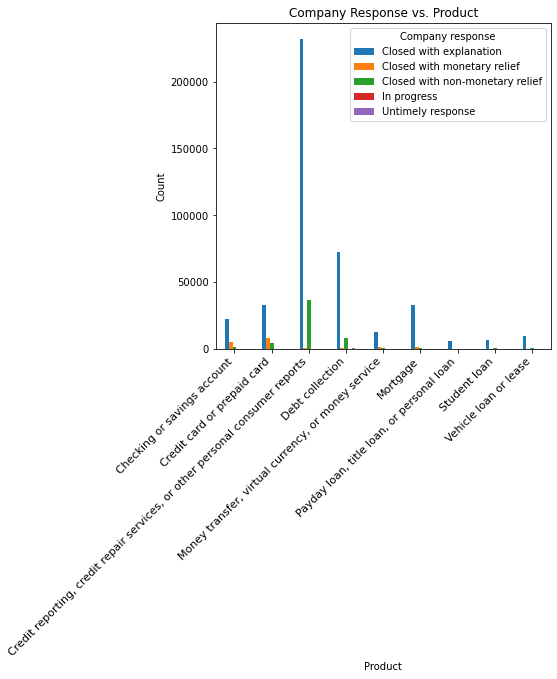

In [205]:
pd.crosstab(df_imputed['Product'],df_imputed['Company_response_to_consumer']).plot(kind='bar',
                                                          title='Company Response vs. Product',figsize=(6,6))
plt.xticks(rotation=45,fontsize=11,ha="right")
plt.ylabel('Count')
plt.xlabel('Product')
plt.legend(title='Company response')

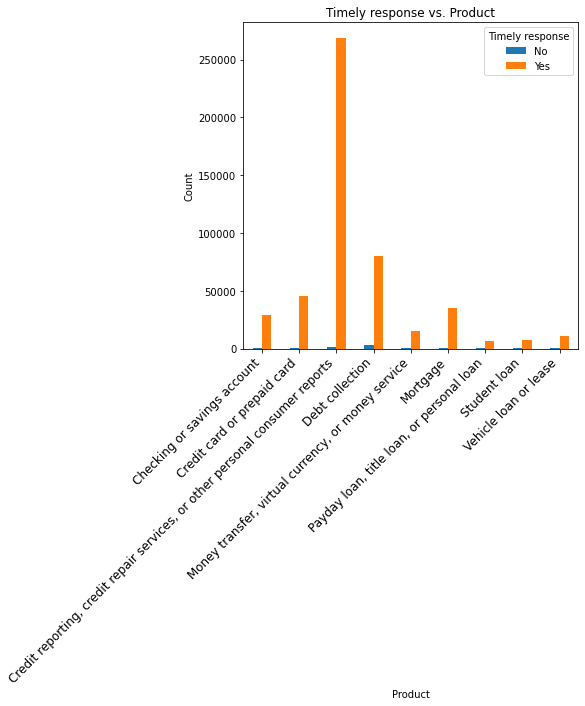

In [206]:
pd.crosstab(df_imputed['Product'],df_imputed['Timely_response']).plot(kind='bar',
                                                          title='Timely response vs. Product',figsize=(6,6))
plt.ylabel('Count')
plt.xlabel('Product')
plt.xticks(rotation=45,fontsize=12,ha="right")
plt.legend(title='Timely response')

Text(0.5, 1.0, 'Complaints by month')

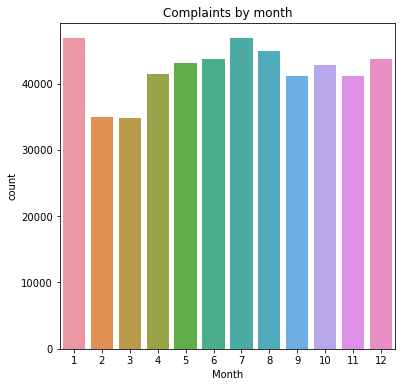

In [207]:
fig,ax = plt.subplots(figsize=(6,6))
pd.options.mode.chained_assignment = None
df_imputed['Date_received'] = pd.to_datetime(df_imputed['Date_received'])
df_imputed['Date_received'].min(),df_imputed['Date_received'].max()
df_imputed['Month'] = df_imputed['Date_received'].dt.month
sns.countplot(x='Month',data=df_imputed).set_title('Complaints by month')
#most complaints in January and July, followed by December

Text(0.5, 1.0, 'Complaints by year')

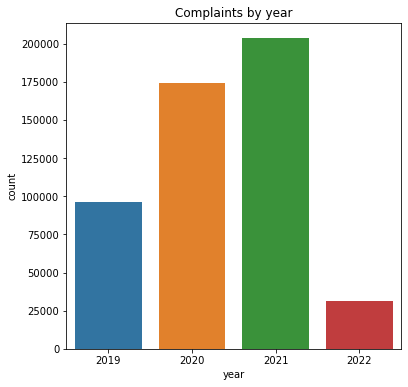

In [208]:
fig,ax = plt.subplots(figsize=(6,6))
df_imputed['year'] = df_imputed['Date_received'].dt.year
sns.countplot(x='year',data=df_imputed).set_title('Complaints by year')
#most complaints in 2021

Text(0.5, 1.0, 'Complaints by quarter')

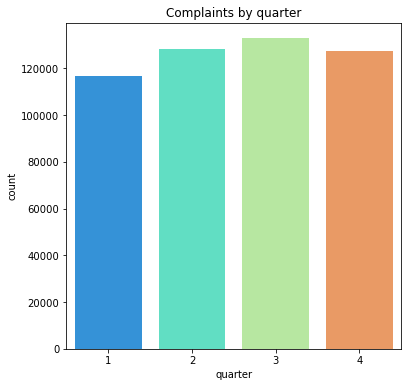

In [209]:
fig,ax = plt.subplots(figsize=(6,6))
df_imputed['quarter'] = df_imputed['Date_received'].dt.quarter
sns.countplot(x='quarter',palette='rainbow',data=df_imputed).set_title('Complaints by quarter')

Text(0.5, 1.0, 'Complaints by day of month')

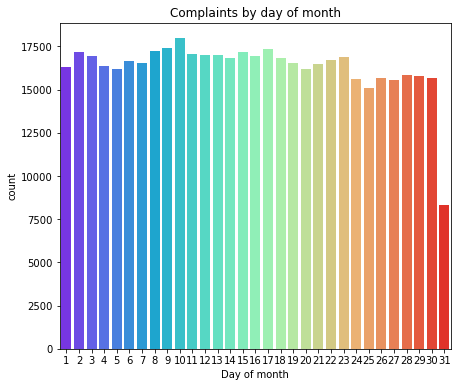

In [210]:
fig,ax = plt.subplots(figsize=(7,6))
df_imputed['Day of month'] = df_imputed['Date_received'].dt.day
sns.countplot(x='Day of month',palette='rainbow',data=df_imputed).set_title('Complaints by day of month')

Text(0.5, 1.0, 'Complaints by day of week')

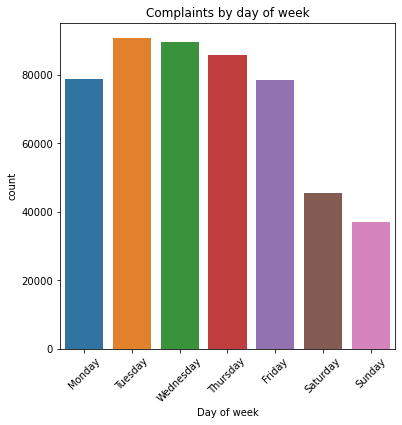

In [211]:
fig,ax = plt.subplots(figsize=(6,6))
df_imputed['Day of week'] = df_imputed['Date_received'].dt.day_name()
plt.xticks(rotation=45)
sns.countplot(x='Day of week',data=df_imputed,
              order= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday',
                      'Sunday']).set_title('Complaints by day of week')
#most complaints in the middle of the week

# Text Data Preprocessing / Text Analysis Feature Engineering

In [212]:
#expand display of column
pd.set_option('display.max_colwidth',100)
tdf = df_imputed[['Product','Consumer_complaint_narrative']].copy()

In [213]:
tdf = tdf[pd.notnull(tdf['Consumer_complaint_narrative'])]

# Renaming second column for a simpler name
tdf.columns = ['Product', 'Consumer_complaint'] 

tdf.shape

(505372, 2)

In [214]:
# Percentage of complaints with text
total = tdf['Consumer_complaint'].notnull().sum()
round((total/len(tdf)*100),1)
#100% of complaints have text data

100.0

In [215]:
pd.DataFrame(tdf.Product.unique()).values

array([['Mortgage'],
       ['Debt collection'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Credit card or prepaid card'],
       ['Checking or savings account'],
       ['Payday loan, title loan, or personal loan'],
       ['Money transfer, virtual currency, or money service'],
       ['Vehicle loan or lease'],
       ['Student loan']], dtype=object)

In [216]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
tdf_1 = tdf.sample(10000, random_state=1).copy()

In [217]:
# Renaming categories
tdf_1.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)


In [218]:
pd.DataFrame(tdf_1.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Mortgage
2,Debt collection
3,Checking or savings account
4,Vehicle loan or lease
5,Credit card or prepaid card
6,Student loan
7,"Money transfer, virtual currency, or money service"
8,"Payday loan, title loan, or personal loan"


In [219]:
# Create a new column 'category_id' with encoded categories 
tdf_1['category_id'] = tdf_1['Product'].factorize()[0]
category_id_df = tdf_1[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
tdf_1.head()

,Product,Consumer_complaint,category_id
100527,"Credit reporting, repair, or other","I would like to request the suppression of the following items from my credit report, which are ...",0
156735,"Credit reporting, repair, or other","XXXX, Experian, XXXX : number of accounts with Delinquency, serious delinquency, length of revo...",0
161381,"Credit reporting, repair, or other",I contacted Transworld Systems Inc for an account that was in their office on XX/XX/2020 in the ...,0
1425313,"Credit reporting, repair, or other",Equifax ; XXXX and XXXX are reporting incorrectly that I am ( 30 ) days late on the XXXX parti...,0
1211023,"Credit reporting, repair, or other","XXXX, experian, and XXXX are reporting accounts on my report that i have no knowledge of. I have...",0


In [2]:
fig = plt.figure(figsize=(8,6))
#colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
   # 'grey','darkblue','darkblue','darkblue']
tdf_1.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color='pink', title= 'Number of Complaints in each Product Category\n')
plt.xlabel('Number of occurrences', fontsize = 10);

NameError: name 'plt' is not defined

In [221]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(tdf_1.Consumer_complaint).toarray()

labels = tdf_1.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 27645 features (TF-IDF score of unigrams and bigrams)


In [222]:
# Find the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Checking or savings account:
  * Most Correlated Unigrams are: bank, branch, deposit
  * Most Correlated Bigrams are: direct deposit, savings account, checking account

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: merchant, citi, card
  * Most Correlated Bigrams are: card company, american express, credit card

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: bank, accounts, report
  * Most Correlated Bigrams are: items credit, identity theft, credit report

==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: debt collector, debt collection, collect debt

==> Money transfer, virtual currency, or money service:
  * Most Correlated Unigrams are: usd, coinbase, paypal
  * Most Correlated Bigrams are: xxxx usd, cash app, used paypal

==> Mortgage:
  * Most Correlated Unigrams are: modification, escrow, mortgage
  * Most Correlated Bigrams are: loan modification, escrow account,

In [223]:
#check count
tdf['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    270098
Debt collection                                                                  82830
Credit card or prepaid card                                                      45781
Mortgage                                                                         35824
Checking or savings account                                                      29392
Money transfer, virtual currency, or money service                               15767
Vehicle loan or lease                                                            10916
Student loan                                                                      7886
Payday loan, title loan, or personal loan                                         6878
Name: Product, dtype: int64

In [224]:
import string
string.punctuation
import nltk
import re

In [235]:
#defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
tdf['Clean_complaint']= tdf['Consumer_complaint'].apply(lambda x:remove_punctuation(x))
tdf[['Consumer_complaint','Clean_complaint']].head()

,Consumer_complaint,Clean_complaint
3,I am the personal representative of my sister 's estate. When preparing to sell her home I disco...,I am the personal representative of my sister s estate When preparing to sell her home I discove...
39,I financed some expensive dental procedures through XXXX XXXX. The contract I signed had no late...,I financed some expensive dental procedures through XXXX XXXX The contract I signed had no late ...
41,Today XX/XX/XXXX went online to dispute the incorrect personal information and it says This requ...,Today XXXXXXXX went online to dispute the incorrect personal information and it says This reques...
73,I have been trying to dispute this inaccurate late payment with comenity bank for months they ar...,I have been trying to dispute this inaccurate late payment with comenity bank for months they ar...
105,"I ordered some clothing online, two purchases in the amounts of {$140.00} & {$81.00} The merchan...",I ordered some clothing online two purchases in the amounts of 14000 8100 The merchandise was n...


In [236]:
tdf['Lower_complaint']= tdf['Clean_complaint'].apply(lambda x: x.lower())
tdf[['Clean_complaint','Lower_complaint']].head()

,Clean_complaint,Lower_complaint
3,I am the personal representative of my sister s estate When preparing to sell her home I discove...,i am the personal representative of my sister s estate when preparing to sell her home i discove...
39,I financed some expensive dental procedures through XXXX XXXX The contract I signed had no late ...,i financed some expensive dental procedures through xxxx xxxx the contract i signed had no late ...
41,Today XXXXXXXX went online to dispute the incorrect personal information and it says This reques...,today xxxxxxxx went online to dispute the incorrect personal information and it says this reques...
73,I have been trying to dispute this inaccurate late payment with comenity bank for months they ar...,i have been trying to dispute this inaccurate late payment with comenity bank for months they ar...
105,I ordered some clothing online two purchases in the amounts of 14000 8100 The merchandise was n...,i ordered some clothing online two purchases in the amounts of 14000 8100 the merchandise was n...


In [237]:
tdf['No_whitespace_complaint']= tdf['Lower_complaint'].apply(lambda x: " ".join(x.split()))
tdf[['Lower_complaint','No_whitespace_complaint']].head()

,Lower_complaint,No_whitespace_complaint
3,i am the personal representative of my sister s estate when preparing to sell her home i discove...,i am the personal representative of my sister s estate when preparing to sell her home i discove...
39,i financed some expensive dental procedures through xxxx xxxx the contract i signed had no late ...,i financed some expensive dental procedures through xxxx xxxx the contract i signed had no late ...
41,today xxxxxxxx went online to dispute the incorrect personal information and it says this reques...,today xxxxxxxx went online to dispute the incorrect personal information and it says this reques...
73,i have been trying to dispute this inaccurate late payment with comenity bank for months they ar...,i have been trying to dispute this inaccurate late payment with comenity bank for months they ar...
105,i ordered some clothing online two purchases in the amounts of 14000 8100 the merchandise was n...,i ordered some clothing online two purchases in the amounts of 14000 8100 the merchandise was ne...


In [238]:
#remove default stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords
from collections import Counter

In [239]:
#tokenized
tdf['Tokenized_complaint']= tdf['No_whitespace_complaint'].apply(lambda x: x.split())
tdf[['No_whitespace_complaint','Tokenized_complaint']].head()

,No_whitespace_complaint,Tokenized_complaint
3,i am the personal representative of my sister s estate when preparing to sell her home i discove...,"[i, am, the, personal, representative, of, my, sister, s, estate, when, preparing, to, sell, her..."
39,i financed some expensive dental procedures through xxxx xxxx the contract i signed had no late ...,"[i, financed, some, expensive, dental, procedures, through, xxxx, xxxx, the, contract, i, signed..."
41,today xxxxxxxx went online to dispute the incorrect personal information and it says this reques...,"[today, xxxxxxxx, went, online, to, dispute, the, incorrect, personal, information, and, it, say..."
73,i have been trying to dispute this inaccurate late payment with comenity bank for months they ar...,"[i, have, been, trying, to, dispute, this, inaccurate, late, payment, with, comenity, bank, for,..."
105,i ordered some clothing online two purchases in the amounts of 14000 8100 the merchandise was ne...,"[i, ordered, some, clothing, online, two, purchases, in, the, amounts, of, 14000, 8100, the, mer..."


In [240]:
stopwords=nltk.corpus.stopwords.words('english')
stopwords[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [241]:
#define the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

In [242]:
tdf['No_stopwords_complaint']=tdf['Tokenized_complaint'].apply(lambda x:remove_stopwords(x))
tdf[['Tokenized_complaint','No_stopwords_complaint']].head()

,Tokenized_complaint,No_stopwords_complaint
3,"[i, am, the, personal, representative, of, my, sister, s, estate, when, preparing, to, sell, her...","[personal, representative, sister, estate, preparing, sell, home, discovered, phh, mortgage, cha..."
39,"[i, financed, some, expensive, dental, procedures, through, xxxx, xxxx, the, contract, i, signed...","[financed, expensive, dental, procedures, xxxx, xxxx, contract, signed, late, fee, interest, com..."
41,"[today, xxxxxxxx, went, online, to, dispute, the, incorrect, personal, information, and, it, say...","[today, xxxxxxxx, went, online, dispute, incorrect, personal, information, says, request, proces..."
73,"[i, have, been, trying, to, dispute, this, inaccurate, late, payment, with, comenity, bank, for,...","[trying, dispute, inaccurate, late, payment, comenity, bank, months, reporting, 1, missed, payme..."
105,"[i, ordered, some, clothing, online, two, purchases, in, the, amounts, of, 14000, 8100, the, mer...","[ordered, clothing, online, two, purchases, amounts, 14000, 8100, merchandise, never, delivered,..."


In [244]:
tdf

,Product,Consumer_complaint,Clean_complaint,Lower_complaint,No_whitespace_complaint,Tokenized_complaint,No_stopwords_complaint
3,Mortgage,I am the personal representative of my sister 's estate. When preparing to sell her home I disco...,I am the personal representative of my sister s estate When preparing to sell her home I discove...,i am the personal representative of my sister s estate when preparing to sell her home i discove...,i am the personal representative of my sister s estate when preparing to sell her home i discove...,"[i, am, the, personal, representative, of, my, sister, s, estate, when, preparing, to, sell, her...","[personal, representative, sister, estate, preparing, sell, home, discovered, phh, mortgage, cha..."
39,Debt collection,I financed some expensive dental procedures through XXXX XXXX. The contract I signed had no late...,I financed some expensive dental procedures through XXXX XXXX The contract I signed had no late ...,i financed some expensive dental procedures through xxxx xxxx the contract i signed had no late ...,i financed some expensive dental procedures through xxxx xxxx the contract i signed had no late ...,"[i, financed, some, expensive, dental, procedures, through, xxxx, xxxx, the, contract, i, signed...","[financed, expensive, dental, procedures, xxxx, xxxx, contract, signed, late, fee, interest, com..."
41,"Credit reporting, credit repair services, or other personal consumer reports",Today XX/XX/XXXX went online to dispute the incorrect personal information and it says This requ...,Today XXXXXXXX went online to dispute the incorrect personal information and it says This reques...,today xxxxxxxx went online to dispute the incorrect personal information and it says this reques...,today xxxxxxxx went online to dispute the incorrect personal information and it says this reques...,"[today, xxxxxxxx, went, online, to, dispute, the, incorrect, personal, information, and, it, say...","[today, xxxxxxxx, went, online, dispute, incorrect, personal, information, says, request, proces..."
73,"Credit reporting, credit repair services, or other personal consumer reports",I have been trying to dispute this inaccurate late payment with comenity bank for months they ar...,I have been trying to dispute this inaccurate late payment with comenity bank for months they ar...,i have been trying to dispute this inaccurate late payment with comenity bank for months they ar...,i have been trying to dispute this inaccurate late payment with comenity bank for months they ar...,"[i, have, been, trying, to, dispute, this, inaccurate, late, payment, with, comenity, bank, for,...","[trying, dispute, inaccurate, late, payment, comenity, bank, months, reporting, 1, missed, payme..."
105,Credit card or prepaid card,"I ordered some clothing online, two purchases in the amounts of {$140.00} & {$81.00} The merchan...",I ordered some clothing online two purchases in the amounts of 14000 8100 The merchandise was n...,i ordered some clothing online two purchases in the amounts of 14000 8100 the merchandise was n...,i ordered some clothing online two purchases in the amounts of 14000 8100 the merchandise was ne...,"[i, ordered, some, clothing, online, two, purchases, in, the, amounts, of, 14000, 8100, the, mer...","[ordered, clothing, online, two, purchases, amounts, 14000, 8100, merchandise, never, delivered,..."
...,...,...,...,...,...,...,...
2563587,"Credit reporting, credit repair services, or other personal consumer reports","I have been patiently waiting on their response about the written requests I sent. However, any ...",I have been patiently waiting on their response about the written requests I sent However any mo...,i have been patiently waiting on their response about the written requests i sent however any mo...,i have been patiently waiting on their response about the written requests i sent however any mo...,"[i, have, been, patiently, waiting, on, their, response, about, the, written, requests, i, sent,...","[pa

# Feature Importance

In [226]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
df4 = df3.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')
df4.head()

,Date_received,Product,Sub_product,Issue,Sub_issue,Consumer_complaint_narrative,Company_public_response,Company,State,Zip_code,Consumer_consent_provided,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Timely_response,Complaint_ID,year_received,month_received
3,1031,5,40,68,162,87385,10,2631,7,17599,0,0,1031,0,1,489681,3,0
39,1067,3,29,17,6,111346,4,1773,7,17541,0,0,1067,0,1,502607,3,5
41,235,2,7,28,90,363302,9,3507,13,7529,0,0,235,0,1,84103,0,2
73,344,2,7,28,3,132685,10,261,42,10382,0,0,344,0,1,122827,1,5
105,373,1,42,50,36,165033,9,670,13,8108,0,0,373,0,1,135562,1,6


In [227]:
#changes to numerical data to determine feature importance
pipeline=autoclean(df4)
pipeline.tail(10)
pipeline.describe(include='all')

,Date_received,Product,Sub_product,Issue,Sub_issue,Consumer_complaint_narrative,Company_public_response,Company,State,Zip_code,Consumer_consent_provided,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Timely_response,Complaint_ID,year_received,month_received
count,505372.000000,505372.000000,505372.000000,505372.000000,505372.000000,505372.000000,505372.000000,505372.000000,505372.000000,505372.000000,505372.0,505372.0,505372.000000,505372.000000,505372.000000,505372.000000,505372.000000,505372.000000
mean,581.572748,2.494109,11.857074,34.667882,84.544660,209723.481960,9.222790,1921.423751,28.057059,10500.582834,0.0,0.0,582.545078,0.270460,0.985399,252685.500000,1.335038,5.527928
std,296.726091,1.546357,9.737354,19.407482,53.393837,121797.916852,1.406222,1135.302699,16.953143,6029.831631,0.0,0.0,297.002425,0.677061,0.119950,145888.474457,0.852719,3.517572
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,352.000000,2.000000,7.000000,26.000000,43.000000,103697.000000,9.000000,1253.000000,13.000000,5780.000000,0.0,0.0,353.000000,0.000000,1.000000,126342.750000,1.000000,2.000000
50%,604.000000,2.000000,7.000000,28.000000,69.000000,208196.000000,10.000000,1347.000000,25.000000,9288.000000,0.0,0.0,606.000000,0.000000,1.000000,252685.500000,1.000000,6.000000
75%,835.000000,3.000000,14.000000,47.000000,139.000000,316478.250000,10.000000,3227.000000,43.000000,16156.000000,0.0,0.0,837.000000,0.000000,1.000000,379028.250000,2.000000,9.000000
max,1087.000000,8.000000,47.000000,79.000000,162.000000,424538.000000,10.000000,3951.000000,61.000000,20872.000000,0.0,0.0,1087.000000,4.000000,1.000000,505371.000000,3.000000,11.000000


In [228]:
pipeline.corr()
#Company has the most correlation with consumer complaint, followed by date, issue, product, etc.

,Date_received,Product,Sub_product,Issue,Sub_issue,Consumer_complaint_narrative,Company_public_response,Company,State,Zip_code,Consumer_consent_provided,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Timely_response,Complaint_ID,year_received,month_received
Date_received,1.000000,-0.039379,-0.039241,0.005045,0.031728,0.007091,0.020269,-0.005850,0.018124,-0.040928,NaN,NaN,0.999852,0.021251,0.011974,0.996752,0.941638,-0.191713
Product,-0.039379,1.000000,0.306643,0.063671,0.291733,0.005227,-0.067540,0.079722,0.015775,0.011593,NaN,NaN,-0.038315,-0.057249,-0.048880,-0.038172,-0.036555,0.004399
Sub_product,-0.039241,0.306643,1.000000,-0.060155,0.008709,-0.005807,-0.057315,-0.011036,0.035246,0.028932,NaN,NaN,-0.037701,-0.013662,-0.063852,-0.038349,-0.035471,0.008518
Issue,0.005045,0.063671,-0.060155,1.000000,0.347862,-0.006068,-0.001233,0.021917,0.009437,-0.013519,NaN,NaN,0.004868,-0.027074,0.009423,0.004353,0.007417,-0.001690
Sub_issue,0.031728,0.291733,0.008709,0.347862,1.000000,-0.004020,-0.003802,0.048843,0.005845,-0.000432,NaN,NaN,0.032003,-0.024064,-0.008969,0.033019,0.030334,-0.007293
Consumer_complaint_narrative,0.007091,0.005227,-0.005807,-0.006068,-0.004020,1.000000,-0.019271,0.082853,0.012915,0.019736,NaN,NaN,0.007089,-0.005623,-0.001692,0.007987,0.007910,-0.010057
Company_public_response,0.020269,-0.067540,-0.057315,-0.001233,-0.003802,-0.019271,1.000000,-0.165700,0.009908,-0.015165,NaN,NaN,0.019678,0.011409,0.011132,0.018958,0.014258,0.011168
Company,-0.005850,0.079722,-0.011036,0.021917,0.048843,0.082853,-0.165700,1.000000,0.004633,0.001349,NaN,NaN,-0.005750,-0.010975,0.013489,-0.005995,0.000921,-0.009744
State,0.018124,0.015775,0.035246,0.009437,0.005845,0.012915,0.009908,0.004633,1.000000,-0.154630,NaN,NaN,0.018155,0.000409,-0.002713,0.019847,0.016297,-0.004624
Zip_code,-0.040928,0.011593,0.028932,-0.013519,-0.000432,0.019736,-0.015165,0.001349,-0.154630,1.000000,NaN,NaN,-0.040763,-0.013477,-0.009284,-0.042123,-0.035542,0.008860


In [229]:
plot=pipeline.drop(columns=['Consumer_consent_provided','Submitted_via'])
plot.corr()

,Date_received,Product,Sub_product,Issue,Sub_issue,Consumer_complaint_narrative,Company_public_response,Company,State,Zip_code,Date_sent_to_company,Company_response_to_consumer,Timely_response,Complaint_ID,year_received,month_received
Date_received,1.000000,-0.039379,-0.039241,0.005045,0.031728,0.007091,0.020269,-0.005850,0.018124,-0.040928,0.999852,0.021251,0.011974,0.996752,0.941638,-0.191713
Product,-0.039379,1.000000,0.306643,0.063671,0.291733,0.005227,-0.067540,0.079722,0.015775,0.011593,-0.038315,-0.057249,-0.048880,-0.038172,-0.036555,0.004399
Sub_product,-0.039241,0.306643,1.000000,-0.060155,0.008709,-0.005807,-0.057315,-0.011036,0.035246,0.028932,-0.037701,-0.013662,-0.063852,-0.038349,-0.035471,0.008518
Issue,0.005045,0.063671,-0.060155,1.000000,0.347862,-0.006068,-0.001233,0.021917,0.009437,-0.013519,0.004868,-0.027074,0.009423,0.004353,0.007417,-0.001690
Sub_issue,0.031728,0.291733,0.008709,0.347862,1.000000,-0.004020,-0.003802,0.048843,0.005845,-0.000432,0.032003,-0.024064,-0.008969,0.033019,0.030334,-0.007293
Consumer_complaint_narrative,0.007091,0.005227,-0.005807,-0.006068,-0.004020,1.000000,-0.019271,0.082853,0.012915,0.019736,0.007089,-0.005623,-0.001692,0.007987,0.007910,-0.010057
Company_public_response,0.020269,-0.067540,-0.057315,-0.001233,-0.003802,-0.019271,1.000000,-0.165700,0.009908,-0.015165,0.019678,0.011409,0.011132,0.018958,0.014258,0.011168
Company,-0.005850,0.079722,-0.011036,0.021917,0.048843,0.082853,-0.165700,1.000000,0.004633,0.001349,-0.005750,-0.010975,0.013489,-0.005995,0.000921,-0.009744
State,0.018124,0.015775,0.035246,0.009437,0.005845,0.012915,0.009908,0.004633,1.000000,-0.154630,0.018155,0.000409,-0.002713,0.019847,0.016297,-0.004624
Zip_code,-0.040928,0.011593,0.028932,-0.013519,-0.000432,0.019736,-0.015165,0.001349,-0.154630,1.000000,-0.040763,-0.013477,-0.009284,-0.042123,-0.035542,0.008860


<AxesSubplot:>

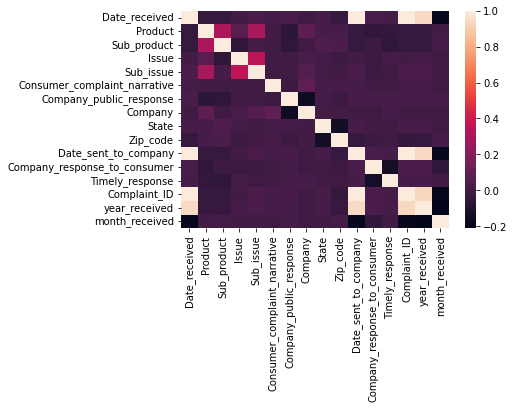

In [230]:
sns.heatmap(plot.corr(),
           xticklabels=plot.corr().columns,
           yticklabels=plot.corr().columns)
#Company has some correlation with consumer complaint

# Model Construction

In [231]:
pipeline.dropna(inplace=True)
feature_cols = ['Date_received','Product','Sub_product','Issue','Sub_issue','Company_public_response','Company',
                'State','Zip_code','Date_sent_to_company','Company_response_to_consumer','Timely_response']
X=pipeline[feature_cols]
y=pipeline['Consumer_complaint_narrative']

In [232]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [233]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.99,train_size=0.01,random_state=1)

Root Mean Squared Error for Random Forest: 46762.20154141706
Root Mean Squared Error for Decision Tree: 186739.69430227327
Root Mean Squared Error for Linear Regression: 121418.89298614192
Date_received                    587.997436
Product                          693.279653
Sub_product                      168.296196
Issue                            127.296565
Sub_issue                         20.965269
Company_public_response          236.308014
Company                            8.183311
State                            244.895528
Zip_code                           0.897433
Date_sent_to_company             574.455994
Company_response_to_consumer    1105.761812
Timely_response                 1719.235938
Name: coefficient, dtype: float64
Root Mean Squared Error for Gradient-Boosted Trees: 116073.45535646482
Ridge model: 587.956 * X0 + 693.277 * X1 + 168.317 * X2 + -127.299 * X3 + -20.963 * X4 + 236.226 * X5 + 8.183 * X6 + 244.896 * X7 + 0.897 * X8 + -574.415 * X9 + -1104.823 * X10 +

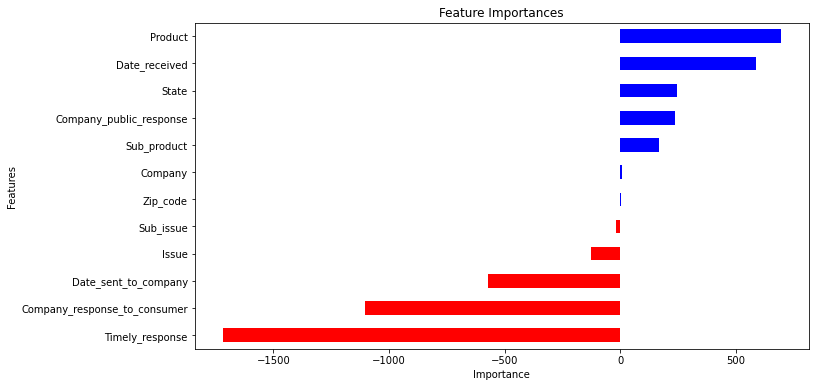

In [234]:
# instantiate the model (using the default parameters)
rf_model= RandomForestRegressor(n_estimators=100)

# fit the model with data
rf_model.fit(X_train,y_train)

rf_model.feature_importances_

sorted_idx = rf_model.feature_importances_.argsort()
plt.barh(feature_cols,rf_model.feature_importances_[sorted_idx],color='orange')
plt.xlabel("Random Forest Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances")
#Most important: Timely response, company response, date sent, zipcode, 
#state, company, company public response, sub-issue, issue, sub-product, product

rmse_rf = mean_squared_error(y_train, rf_model.predict(X_train), squared=False)
print('Root Mean Squared Error for Random Forest:',rmse_rf)

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

dt_model=DecisionTreeClassifier(max_depth=10,min_samples_split=30)

dt_model.fit(X_train,y_train)

dt_model.feature_importances_

sorted_idx = dt_model.feature_importances_.argsort()
plt.barh(feature_cols,dt_model.feature_importances_[sorted_idx],color='orange')
plt.xlabel("Decision Tree Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances")
#most important: timely response, company response, state

#reg = DecisionTreeRegressor(criterion='mae')
#print("Mean Squared Error for LR:",mse)
rmse_dt = mean_squared_error(y_train, dt_model.predict(X_train), squared=False)
print('Root Mean Squared Error for Decision Tree:',rmse_dt)

# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

# define the model
lr_model = LinearRegression()

# fit the model
lr_model.fit(X_train, y_train)

# get importance
importance = lr_model.coef_

coeff = list(importance)
labels = list(X_train.columns)
features = pd.DataFrame()
features['Features'] = labels
features['importance'] = coeff
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(11, 6),color = features.positive.map({True: 'blue', False: 'red'}))
plt.xlabel('Importance')
#timely response, company response, and date sent have a negative influence on the consumer complaint.
#product, date received, state, company response, and sub product have positive influence.

from statistics import mean
predictions =  lr_model.predict(X_train)

rmse_lr = mean_squared_error(y_train, predictions, squared=False)
print('Root Mean Squared Error for Linear Regression:',rmse_lr)

intercept = lr_model.intercept_
features = pd.DataFrame(importance, X_train.columns, columns=['coefficient'])
features
#coefficients farthest from 0: timely response, company response, product, date sent

features.coefficient = features.coefficient.abs()
print(features.coefficient)

# fit model to training data






from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(n_estimators=500, max_depth=4, min_samples_split= 5,
    learning_rate=0.01)
reg.fit(X_train, y_train)


rmse_gb= mean_squared_error(y_train, reg.predict(X_train),squared=False)
print('Root Mean Squared Error for Gradient-Boosted Trees:',rmse_gb)

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange

# define model
ridge = Ridge(alpha=1.0)
# fit model
ridge.fit(X_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


# printing the coefficients
def print_coefs(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

print ("Ridge model:", print_coefs(ridge.coef_))
#significant features: product, issue, company response, timely response

rmse_ridge = mean_squared_error(y_train, ridge.predict(X_train), squared=False)
print('Root Mean Squared Error for Ridge Regression:',rmse_ridge)

print('Root Mean Squared Error for Linear Regression:',rmse_lr)
print('Root Mean Squared Error for Ridge Regression:',rmse_ridge)
print('Root Mean Squared Error for Decision Tree:',rmse_dt)
print('Root Mean Squared Error for Random Forest:',rmse_rf)
print('Root Mean Squared Error for Gradient-Boosted Trees:',rmse_gb)
#smallest RMSE is Random Forest so we choose this model